In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)  # Показывать все столбцы
#pd.set_option('display.max_rows', None)  # и строки
df_train = pd.read_csv('../src/train1.csv')
X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]
X_test = pd.read_csv('../src/test1.csv').iloc[:,:-1]
y_test = pd.read_csv('../src/submission.csv').drop('Id',axis=1)

In [2]:
# разбиваем на категораильные и числовые

#
categorical_columns = X_train.select_dtypes(include=['object', 'category'])
num_columns = X_train.drop([*categorical_columns,'Id'],axis=1)
num_columns = num_columns.fillna(num_columns.mean()) 

threshold = 0.8
categorical_columns = categorical_columns.dropna(axis=1, thresh=len(categorical_columns) - threshold) # если много пропусков в категориальном столбце

for x in categorical_columns:
    categorical_columns[x] = categorical_columns[x].fillna(categorical_columns[x].mode()[0])
# Проверяем, не закодированы ли они ужЕ через LabelEncoding    
for col in num_columns:
    if num_columns[col].nunique() < 17:
        categorical_columns[col] = num_columns[col]
        num_columns = num_columns.drop(col,axis=1)
# делаем frequency_encoding, т.к. категорий получается очень много
for x in categorical_columns:
    frequency_encoding = categorical_columns[x].value_counts(normalize=True).to_dict() 
    categorical_columns[x] = categorical_columns[x].map(frequency_encoding)


In [3]:
from sklearn.feature_selection import mutual_info_regression,SelectKBest # здесь выбираем лучшие признаки
categ_res = SelectKBest(mutual_info_regression,k=15) # у нас 15 признаков с p-value реально большим, поэтому мы не можем пока что сказать "пусть у нас будет 3 признака"
'''до этого момента всё более-менее прозрачно. А потом не понятно, надо ли кодировать, не надо ли.
Тот мужик писал, что RFC работает нормально и с freq enc, но почему тогда? И почему для линейных моделей нельзя использовать freq_enc? А если я с начала
сделаю freq_enc, затем впихну эти признаки в дерево, оно отберет лучшие, то зачем мне тогда смотреть за новой моделью, если я бы мог оставить это дерево для
решения своей задачи? Ну мол, оно мне и так выбрало лучшие признаки, с которыми у него лучшее score, почему бы его не оставить?
'''
'''Итак, касаемо этого, если признаков реально много, то лучше оставить всё в дереве, чем бабахать 200 бинарных столбцов, там любая модель переобучится.
Если же у тебя мало категориальных переменных и числовые данные все линейные, то лучше переделай в OHE и сделай линейную модель. Это будет лучше в 
интерпретации (не просто, что фича "очень важна", а что если увеличить A на 1, то B увеличится на β), скорости, модель меньше будет занимать памяти. '''

categ_res.fit(categorical_columns,y_train)
selected_categorical_columns = categorical_columns[categorical_columns.columns[categ_res.get_support()]]

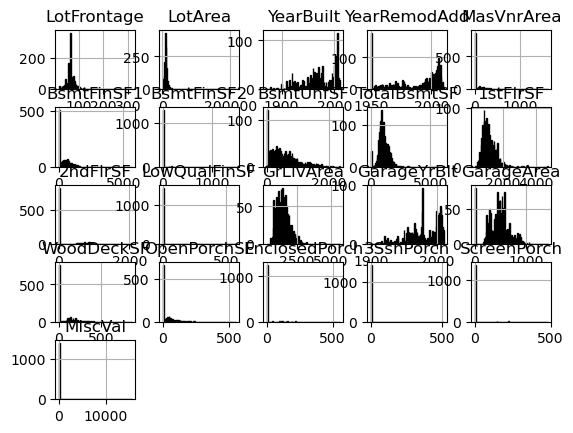

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'MiscVal'],
      dtype='object')


In [4]:
import matplotlib.pyplot as plt # теперь смотрим на числовые переменные

# Для одного признака
num_columns.hist(bins=100, edgecolor='black')
plt.title('Распределение признака your_column')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.show()
print(num_columns.columns) # заметь, что здесь не значения, а именно распределение количества значений, т.е. тут не надо никаких min max scaler.

In [5]:
# не пойму, почему, но VarThresh не работает 
num_columns = num_columns[['LotFrontage','LotArea','YearBuilt','YearRemodAdd','BsmtUnfSF','TotalBsmtSF','1stFlrSF','GrLivArea','GarageYrBlt','GarageArea']]
corr_matrix = num_columns.corr()
threshold = 0.8
to_drop = []
for column in corr_matrix.columns:
    # Проверяем, есть ли корреляция выше порога с другими признаками (кроме самой колонки)
    correlated_features = corr_matrix[column].abs() > threshold
    correlated_features[column] = False  # Не учитываем корреляцию с самой собой
    if any(correlated_features):  # Если есть хоть один признак, коррелирующий с текущим выше порога
        to_drop.append(column)

# Удаляем коррелирующие признаки
num_cols_cleaned = num_columns.drop(columns=to_drop)
# Печатаем список удалённых признаков
print("Удалённые признаки:", to_drop)
# Проверяем размерность данных после удаления
print(num_cols_cleaned.shape,selected_categorical_columns.shape)

Удалённые признаки: ['TotalBsmtSF', '1stFlrSF']
(1460, 8) (1460, 15)


In [20]:
from sklearn.ensemble import RandomForestRegressor 
import pandas as pd
model = RandomForestRegressor(min_samples_leaf=4)
X_train = pd.concat([num_cols_cleaned,selected_categorical_columns],axis=1)
#делаем модель для того, чтобы определить features_importance, она определяет, сколько неопределённости из данных уйдёт, если добавить этот признак (0.1 - сокращает на 10%)
model.fit(X_train,y_train)
threshold = 0.05  # Установим порог
selected_features = [i for i in range(X_train.shape[1]) if model.feature_importances_[i] > threshold]
X_train = X_train[X_train.columns[selected_features]]
# X_train, итак, мы получили свои заслуженные топ 5 фич, теперь делаем преобразование для X_test и y_test.

In [21]:
X_test = X_test[X_train.columns]

for x in ['ExterQual','OverallQual']:
    X_test[x] = X_test[x].fillna(X_test[x].mode()[0])
    frequency_encoding = X_test[x].value_counts(normalize=True).to_dict() 
    X_test[x] = X_test[x].map(frequency_encoding)
X_test['GarageArea'] =  X_test['GarageArea'].fillna(X_test['GarageArea'].mean())
model.fit(X_train,y_train)
print(f'{model.score(X_test,y_test)} при {len(X_test.columns)} столбцов из 79'.center(70,'🎻'))

🎻🎻🎻🎻🎻🎻🎻🎻🎻🎻🎻🎻🎻🎻🎻0.8858656145654273 при 5 столбцов из 79🎻🎻🎻🎻🎻🎻🎻🎻🎻🎻🎻🎻🎻🎻🎻🎻
